# Predict People Flow by using RNN

In [127]:
import numpy as np
import torch

In [128]:
import matplotlib.pyplot as plt
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################
plt.rcParams.update({'axes.grid'     : True})

## Data Preparation

In [129]:
import pandas as pd

path = '../data/num_file/p040.csv'
p003 = pd.read_csv(path)

Merge "date" and "hour" columns to be datetime

In [130]:
p003['datetime'] = pd.to_datetime(p003['date'])+pd.to_timedelta(p003['hour'], unit='h')
p003 = p003.drop(['date', 'hour'], axis=1)
p003.set_index('datetime', inplace=True)
p003.columns=['y']
p003['y'] = p003['y'].astype(float)
print(p003)

                           y
datetime                    
2022-04-21 01:00:00   1033.0
2022-04-21 02:00:00     65.0
2022-04-21 12:00:00   1604.0
2022-04-25 15:00:00   4458.0
2022-04-25 16:00:00  18501.0
...                      ...
2022-09-03 07:00:00   9741.0
2022-09-03 08:00:00  19613.0
2022-09-03 09:00:00  22055.0
2022-09-03 10:00:00  14644.0
2022-09-03 11:00:00  12751.0

[3144 rows x 1 columns]


Resample the data that are not existed

In [131]:
p003 = p003.resample('H').mean()
p003.index.freq = 'H'
print(p003)

                           y
datetime                    
2022-04-21 01:00:00   1033.0
2022-04-21 02:00:00     65.0
2022-04-21 03:00:00      NaN
2022-04-21 04:00:00      NaN
2022-04-21 05:00:00      NaN
...                      ...
2022-09-03 07:00:00   9741.0
2022-09-03 08:00:00  19613.0
2022-09-03 09:00:00  22055.0
2022-09-03 10:00:00  14644.0
2022-09-03 11:00:00  12751.0

[3251 rows x 1 columns]


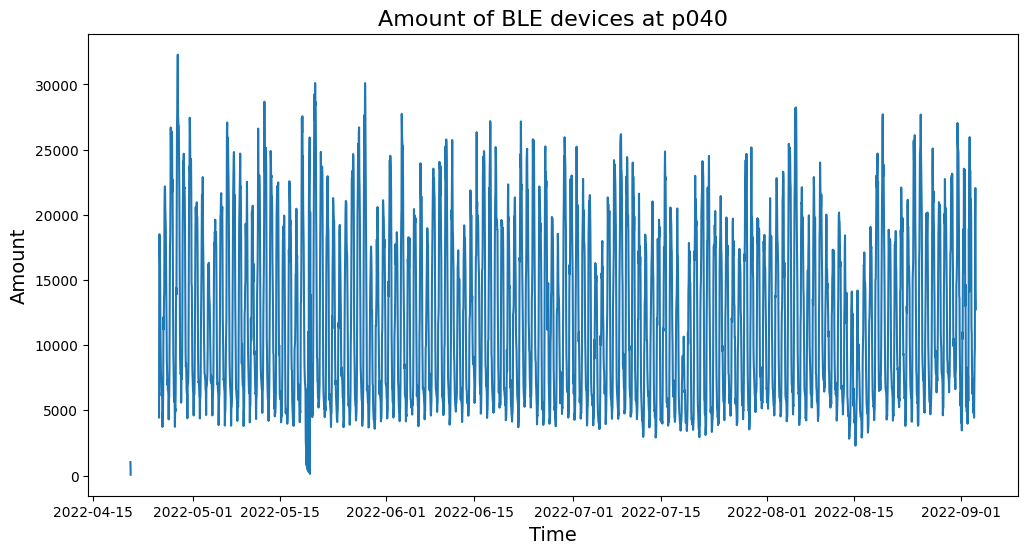

In [132]:
plt.title("Amount of BLE devices at p040")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.grid()
plt.plot(p003['y'])

In [133]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression

estimators = [
    # ('extra_trees', ExtraTreesRegressor(n_estimators=10)),
    # ('bagging', BaggingRegressor(n_estimators=10)),
    # ('elastic_net', ElasticNet()),
    # ('linear_regression', LinearRegression()),
    ('knn', KNeighborsRegressor(n_neighbors=3))
]

In [134]:
p003_vals = p003.iloc[:, 0:3].values

for e_name, e in estimators:
    est = IterativeImputer(random_state=15, estimator=e).fit(p003_vals)
    p003['y'] = est.transform(p003_vals)[:]

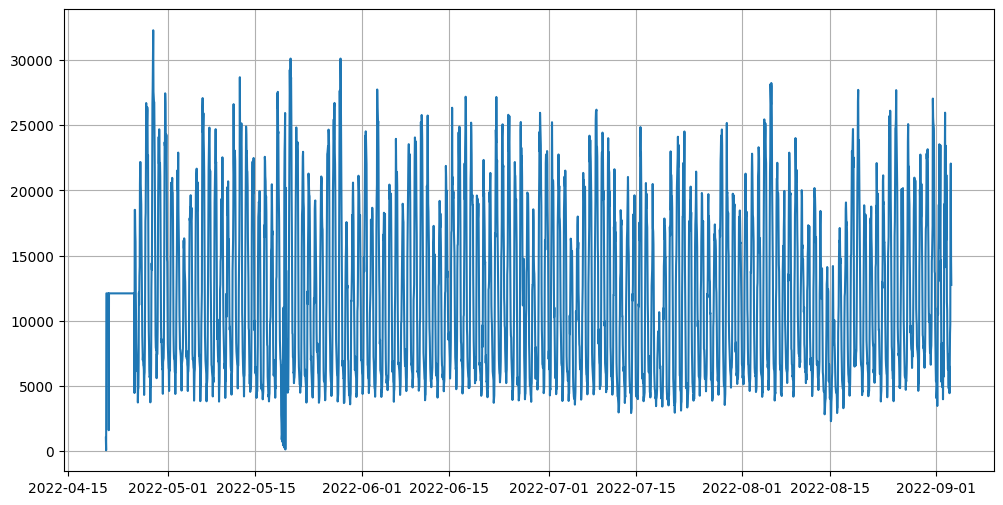

In [135]:
plt.plot(p003['y'])

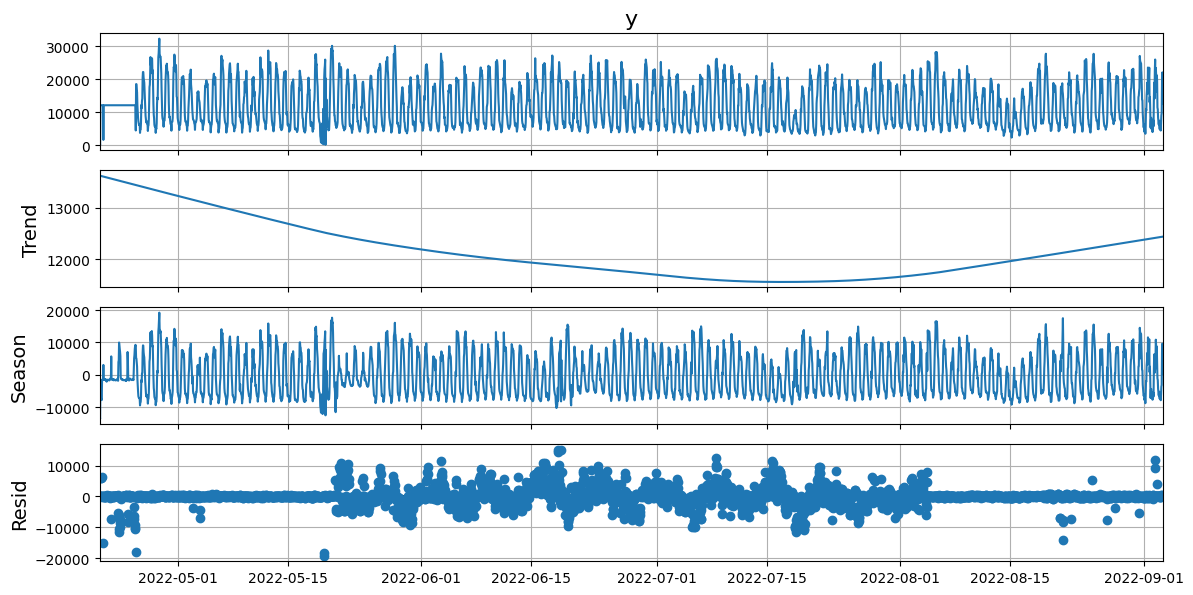

In [136]:
from statsmodels.tsa.seasonal import STL
stl = STL(p003['y'], period=720, robust=True).fit()

stl.plot()
plt.show()

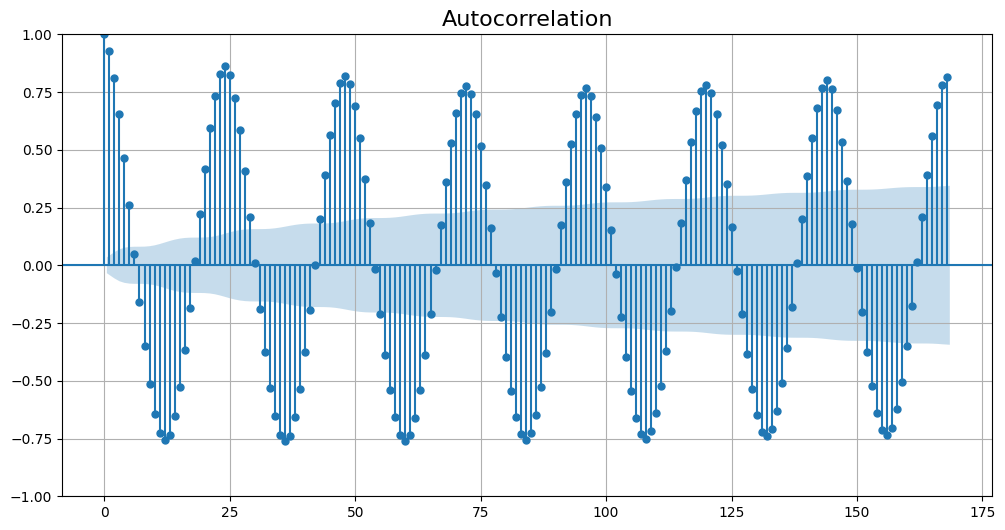

In [137]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(p003['y'], lags=168)

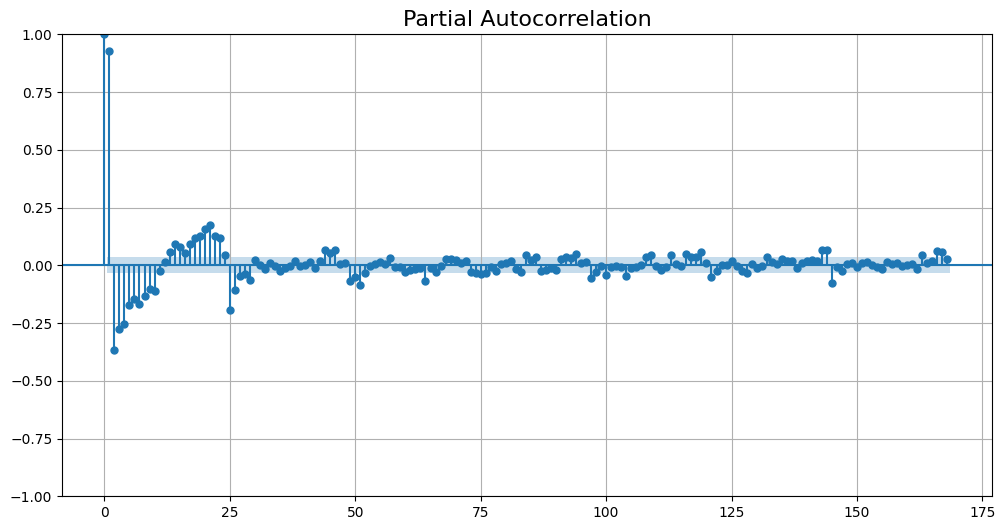

In [138]:
pacf = plot_pacf(p003['y'], lags=168)

# Transform the data

### Windowing

In [139]:
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
        
        
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()
    

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [140]:
p003_cp = p003.copy()
handle_missing_data(p003_cp)

C:\Users\pongs\AppData\Local\Temp\ipykernel_23432\3588771845.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n = int(df.isna().sum())


In [141]:
window_step = 2
p003_df = one_step_forecast(p003_cp, window_step)
print(p003_df.shape)

(3249, 3)


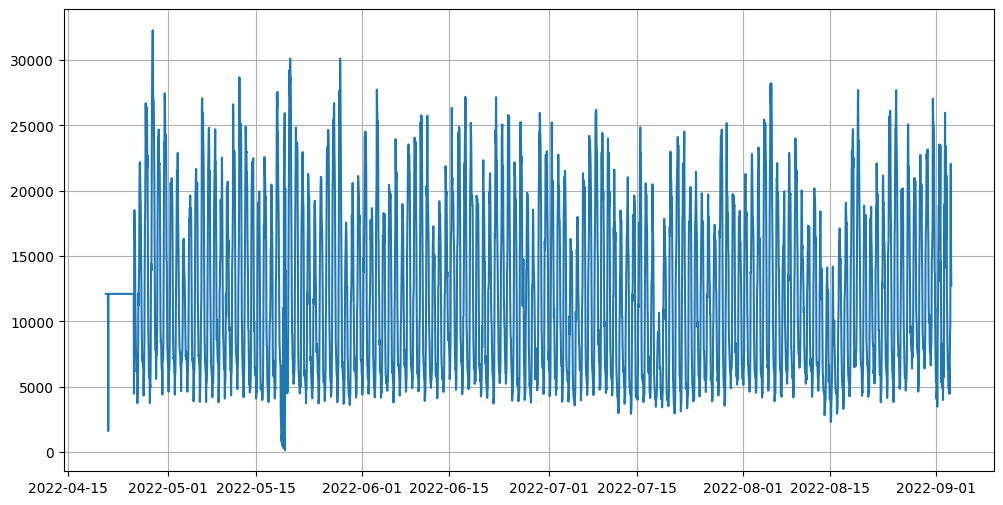

In [142]:
plt.plot(p003_df['y'])

### Scale and split data

In [143]:
class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

In [144]:
scale_p003 = Standardize(p003_df)
train_p003, test_p003, val_p003 = scale_p003.fit_transform()

In [145]:
print(f'''
train: {len(train_p003)}, test: {len(test_p003)}, val: {len(val_p003)}
      ''')


train: 2633, test: 324, val: 292
      


### Split into X and Y (Features and Target)

Create the features_target_pt func to return a PyTorch Tensor object

In [146]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [147]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


In [148]:
def features_target_pt(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x

Split the train, validate, and test sets into x and y

In [149]:
(y_train, y_val, y_test, x_train, x_val, x_test) = features_target_pt(train_p003, val_p003, test_p003)

In [150]:
y_train = y_train.to(device)
y_val = y_val.to(device)
y_test = y_test.to(device)
x_train = x_train.to(device)
x_test = x_test.to(device)
x_val = x_val.to(device)

Check type and len

In [151]:
type(x_test)

torch.Tensor

In [152]:
y_train.shape

torch.Size([2633, 1])

In [153]:
x_train.shape

torch.Size([2633, 2, 1])

## RNN Model

The math from the PyTorch RNN class documentation

$$
\large
h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})
$$

In [154]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.rnn = nn.RNN(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        rnn_o, hn = self.rnn(x, hn)
        rnn_o = self.dropout(rnn_o)
        # reshape
        rnn_o = rnn_o.view(-1, self.hidden_dim)
        output = self.fc(rnn_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

In [155]:
issubclass(RNN, nn.Module)

True

Create the train_model_pt func

In [156]:
def train_model_pt(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    
    if model_type=='RNN':
        model = RNN(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='GRU':
         model = GRU(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    
    model.to(device)
    # Define Loss Function
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    # Extract the training, testing and validation sets
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    # Define a history object to keep track of the train and val loss
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--', label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    actual = scale.inverse_y(y_test.detach().cpu().numpy().ravel())
    pred = scale.inverse_y(y_hat.detach().cpu().numpy().ravel())
    idx = kwargs['idx']
    pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred, index=idx).plot(style='k', label='forecast')
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history

In the preceding code, we are looping through each epoch, initializing the hidden state ($W_{hh}$). On each iteration, we will evaluate on the validation set and store both results from training and validation

### Training and Testing

In [157]:
params = {
    'input_size': x_train.shape[1],
    'output_size': 1,
    'units': 32,
    'n_layers': window_step,
    'epochs': 1000,
    'print_every': 50,
    'lr': 0.01,
    'train_data': (x_train, y_train),
    'val_data': (x_val, y_val),
    'test_data': (x_test, y_test),
    'idx': test_p003.index,
    'scale': scale_p003
}

0/1000 - Loss:  0.990410566329956, val_loss: 0.41677629947662354


50/1000 - Loss:  0.09325100481510162, val_loss: 0.0671960711479187
100/1000 - Loss:  0.07776421308517456, val_loss: 0.053899236023426056
150/1000 - Loss:  0.07307016849517822, val_loss: 0.05280561372637749
200/1000 - Loss:  0.07149972021579742, val_loss: 0.05794776603579521
250/1000 - Loss:  0.06351800262928009, val_loss: 0.05935307592153549
300/1000 - Loss:  0.05690567567944527, val_loss: 0.0602535605430603
350/1000 - Loss:  0.057731661945581436, val_loss: 0.06299947947263718
400/1000 - Loss:  0.054161325097084045, val_loss: 0.06464749574661255
450/1000 - Loss:  0.05318228900432587, val_loss: 0.06974969804286957
500/1000 - Loss:  0.05399034917354584, val_loss: 0.07147041708230972
550/1000 - Loss:  0.05139867961406708, val_loss: 0.07057391852140427
600/1000 - Loss:  0.05168648436665535, val_loss: 0.06460880488157272
650/1000 - Loss:  0.046318911015987396, val_loss: 0.06974621117115021
700/1000 - Loss:  0.047403231263160706, val_loss: 0.0789308249950409
750/1000 - Loss:  0.0432100817561

C:\Users\pongs\AppData\Local\Temp\ipykernel_23432\2853286262.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (data * self.sigma[-1])+self.mu[-1]


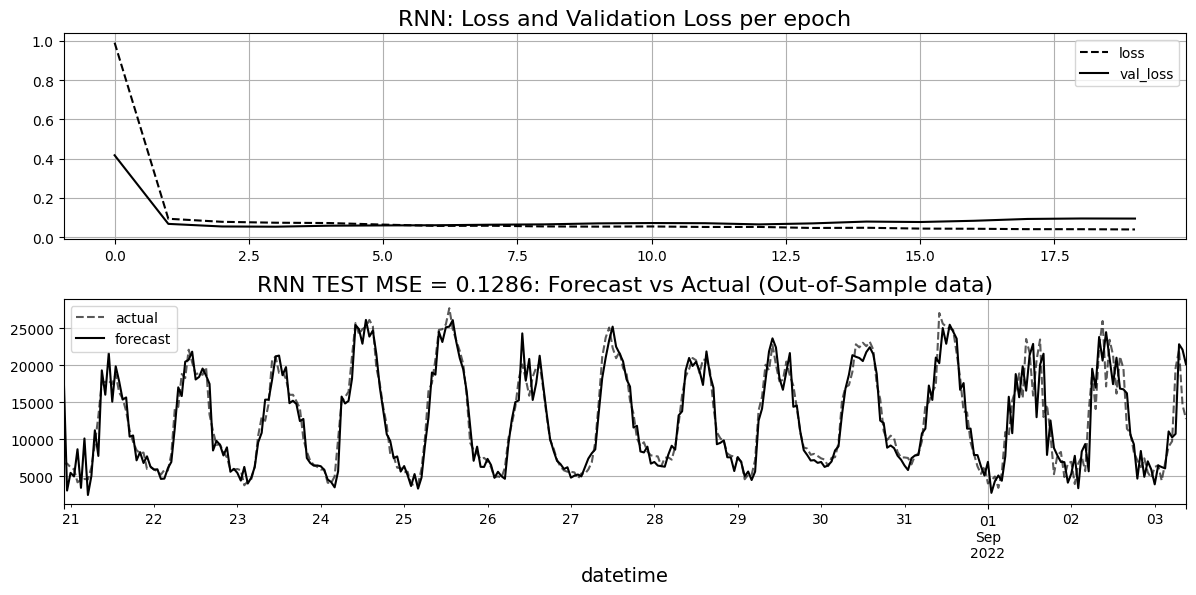

In [158]:
p003_rnn, history_rnn = train_model_pt('RNN', **params)

## LSTM Model

The math from PyTorch LSTM class documentation

$$
\large
\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}
$$

In [159]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

0/1000 - Loss:  0.9955012798309326, val_loss: 0.7396119236946106
50/1000 - Loss:  0.09189919382333755, val_loss: 0.07305192202329636
100/1000 - Loss:  0.0733625665307045, val_loss: 0.05251483991742134
150/1000 - Loss:  0.06872536242008209, val_loss: 0.0474894680082798
200/1000 - Loss:  0.06121908128261566, val_loss: 0.04723302274942398
250/1000 - Loss:  0.05984419584274292, val_loss: 0.046326037496328354
300/1000 - Loss:  0.05588483810424805, val_loss: 0.04697318747639656
350/1000 - Loss:  0.049749720841646194, val_loss: 0.04602909833192825
400/1000 - Loss:  0.04910482466220856, val_loss: 0.0445665568113327
450/1000 - Loss:  0.04672291874885559, val_loss: 0.04596368595957756
500/1000 - Loss:  0.04267431050539017, val_loss: 0.04792183265089989
550/1000 - Loss:  0.04537754878401756, val_loss: 0.055112484842538834
600/1000 - Loss:  0.04288211837410927, val_loss: 0.05380426347255707
650/1000 - Loss:  0.04042352735996246, val_loss: 0.05696358159184456
700/1000 - Loss:  0.038381267338991165,

C:\Users\pongs\AppData\Local\Temp\ipykernel_23432\2853286262.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (data * self.sigma[-1])+self.mu[-1]


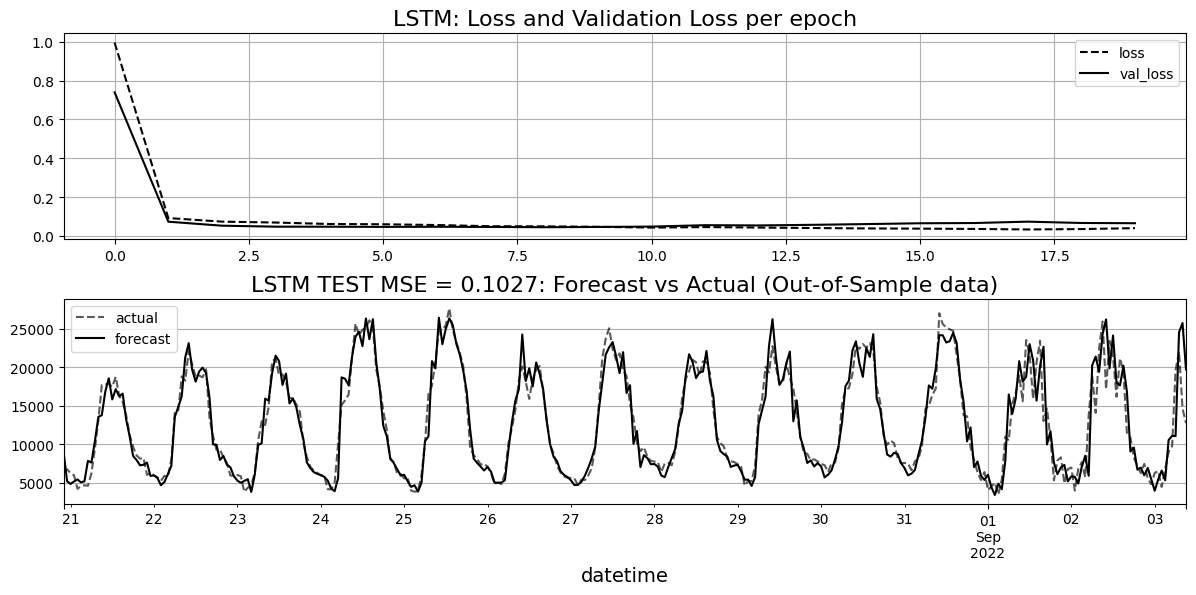

In [160]:
p003_lstm, history_lstm = train_model_pt('LSTM', **params)

In [161]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True, dropout=0.70)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

0/1000 - Loss:  0.9824073314666748, val_loss: 0.7078981995582581
50/1000 - Loss:  0.11701234430074692, val_loss: 0.09494197368621826
100/1000 - Loss:  0.09441190958023071, val_loss: 0.06183890625834465
150/1000 - Loss:  0.09090886265039444, val_loss: 0.060424987226724625
200/1000 - Loss:  0.080751433968544, val_loss: 0.05601021274924278
250/1000 - Loss:  0.07830196619033813, val_loss: 0.057319000363349915
300/1000 - Loss:  0.0748407244682312, val_loss: 0.05409090593457222
350/1000 - Loss:  0.07004271447658539, val_loss: 0.05719125270843506
400/1000 - Loss:  0.07230329513549805, val_loss: 0.07079778611660004
450/1000 - Loss:  0.06834042817354202, val_loss: 0.0536784790456295
500/1000 - Loss:  0.06933356076478958, val_loss: 0.052537329494953156
550/1000 - Loss:  0.0654062032699585, val_loss: 0.055171262472867966
600/1000 - Loss:  0.06151861697435379, val_loss: 0.051459554582834244
650/1000 - Loss:  0.06070772930979729, val_loss: 0.0528419055044651
700/1000 - Loss:  0.06022453308105469, v

C:\Users\pongs\AppData\Local\Temp\ipykernel_23432\2853286262.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (data * self.sigma[-1])+self.mu[-1]


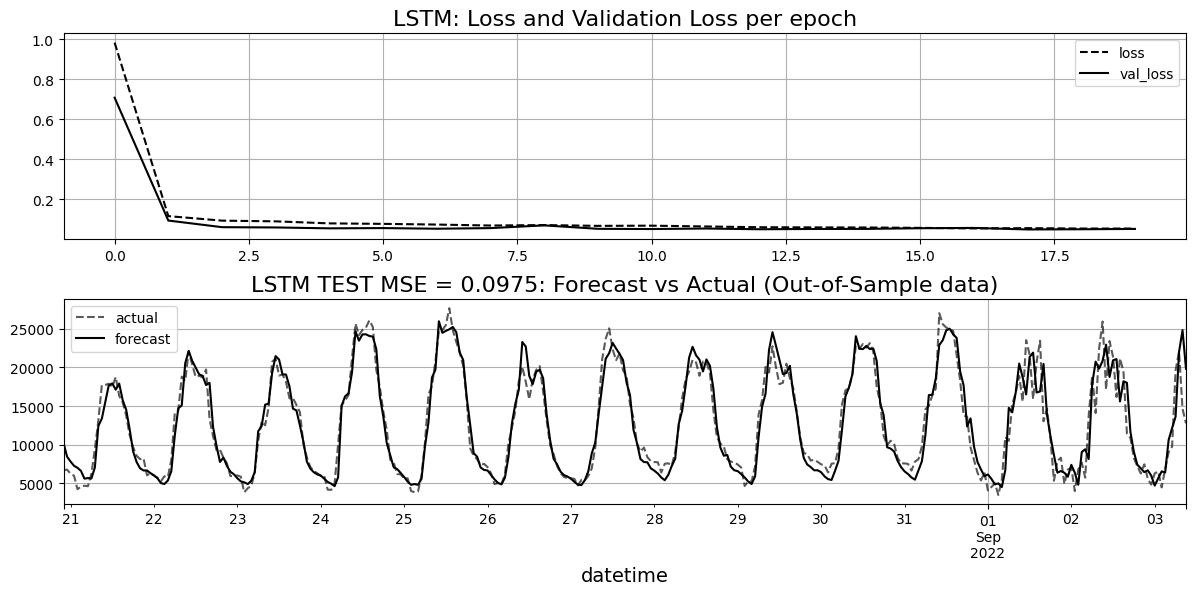

In [162]:
p003_lstm_d, history_lstm_d = train_model_pt('LSTM', **params)

## GRU Model

The math from PyTorch LSTM class documentation

$$
\large
\begin{array}{ll}
        r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
        z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
        n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
        h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
    \end{array}
$$

In [163]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.gru = nn.GRU(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        gru_o, hn = self.gru(x, hn)
        gru_o = self.dropout(gru_o)
        # reshape
        gru_o = gru_o.view(-1, self.hidden_dim)
        output = self.fc(gru_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, 1, self.hidden_dim).zero_()
        return hidden

0/1000 - Loss:  1.2043004035949707, val_loss: 0.7589660882949829
50/1000 - Loss:  0.09115979820489883, val_loss: 0.06111408397555351
100/1000 - Loss:  0.07733036577701569, val_loss: 0.06154964864253998
150/1000 - Loss:  0.06961438059806824, val_loss: 0.051712509244680405
200/1000 - Loss:  0.062168922275304794, val_loss: 0.04695263132452965
250/1000 - Loss:  0.056787215173244476, val_loss: 0.04328194633126259
300/1000 - Loss:  0.05518021062016487, val_loss: 0.045968323945999146
350/1000 - Loss:  0.05256056413054466, val_loss: 0.044465601444244385
400/1000 - Loss:  0.04914194718003273, val_loss: 0.04547693580389023
450/1000 - Loss:  0.04831138998270035, val_loss: 0.045836884528398514
500/1000 - Loss:  0.04323422536253929, val_loss: 0.049386538565158844
550/1000 - Loss:  0.043412867933511734, val_loss: 0.05015728622674942
600/1000 - Loss:  0.04034829139709473, val_loss: 0.05155840888619423
650/1000 - Loss:  0.03597841039299965, val_loss: 0.05645017698407173
700/1000 - Loss:  0.03569795191

C:\Users\pongs\AppData\Local\Temp\ipykernel_23432\2853286262.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (data * self.sigma[-1])+self.mu[-1]


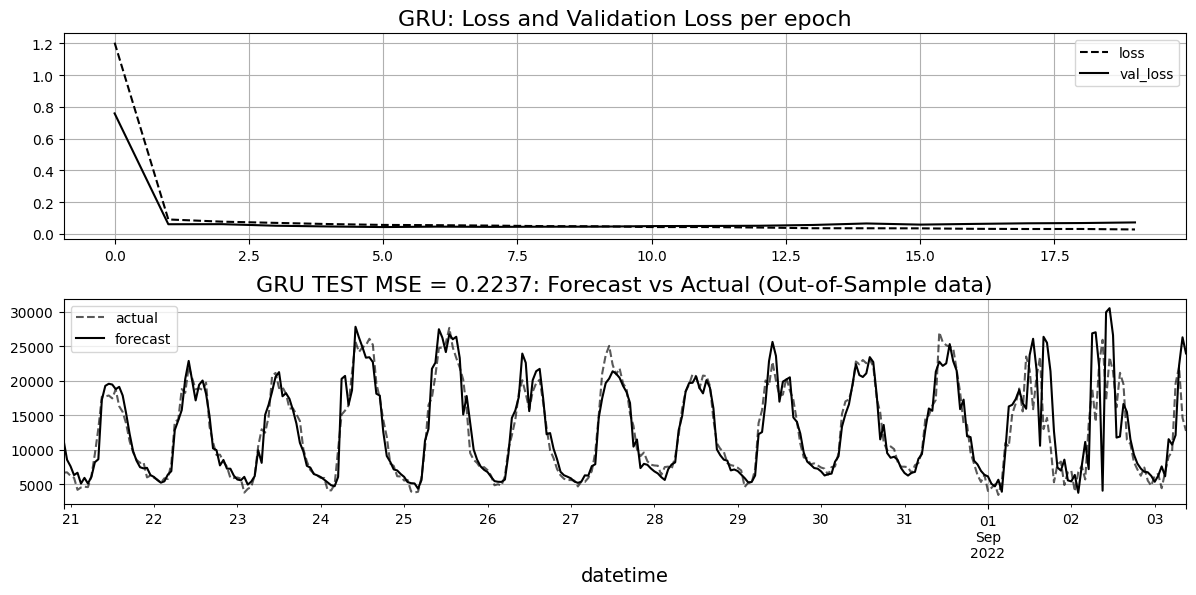

In [164]:
p003_gru, history_gru = train_model_pt('GRU', **params)